CS109a Final Project Milestone 3 

Group 32

Members: Andra Fehmiu, Shih-Yi Tseng, Liam Corrigan, Alkmini Chalofti

Project: Spotify project

Import libraries

In [1]:
import sys, os
import sqlite3
import pandas as pd
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

Create/connect to database

In [2]:
# create a new database by connecting to it
conn = sqlite3.connect("spotifyDB.db")
cur = conn.cursor()

Create tables for playlists and tracks

In [ ]:
# create the tracks table

cur.execute('''CREATE TABLE IF NOT EXISTS tracks (track text PRIMARY KEY,
         track_name text, album text, album_name text, artist text, artist_name text, 
         duration_ms integer, playlist_member text, num_member integer
         );''')

conn.commit()

In [ ]:
# create playlists table

cur.execute('''CREATE TABLE IF NOT EXISTS playlists (playlist_id INTEGER PRIMARY KEY AUTOINCREMENT,
         playlist_name TEXT, collaborative TEXT, modified_at INTEGER, num_tracks INTEGER, num_albums INTEGER,
         num_artists INTEGER, num_followers INTEGER, num_edits INTEGER, playlist_duration_ms INTEGER, 
         tracks TEXT);''')

conn.commit()

Collect paths to Million Playlist Files

In [ ]:
mpd_path ='C:\\Users\\Shih-Yi\\Documents\\mpd.v1\\mpd\\data'
playlist_path = []

for path, subdirs, files in os.walk(mpd_path):
    for name in files:
        if name.endswith('.json'):
            playlist_path.append(os.path.join(path, name))

Define functions for processing playlists data 

In [ ]:
def process_playlist(playlist_dict):
    columns = ['playlist_name','collaborative','modified_at','num_tracks','num_albums',
               'num_artists','num_followers','num_edits','duration_ms']
    
    playlist = {}
    
    for col in columns:
        if col in playlist_dict.keys():
            playlist[col] = playlist_dict[col]
        else:
            playlist[col] = None
            
    if 'name' in playlist_dict.keys() and playlist['playlist_name'] == None:
        playlist['playlist_name'] =playlist_dict['name']
        
    all_track_uri = [tr['track_uri'].split(':')[-1] for tr in playlist_dict['tracks']]
    all_track_uri = ','.join(set(all_track_uri)) # take unique tracks
    playlist['tracks'] = all_track_uri
    playlist['playlist_duration_ms'] = playlist.pop('duration_ms')
    
    playlist_df = pd.DataFrame(playlist, index=[0])
    playlist_df = playlist_df.set_index('playlist_name')
    
    return playlist_df

def clean_uri(track,uri):
    if type(track[uri])!=type(None):
        cleaned_uri = track[uri].split(':')[-1]
    elif type(track[uri])==type(None):
        cleaned_uri = ''
    return cleaned_uri 

def process_tracks_into_df(tracks, playlist_id):
    # convert tracks into dataframe
    tracks_df = pd.DataFrame.from_dict(tracks)
    # remove duplicates of tracks
    tracks_df = tracks_df.drop_duplicates('track_uri')
    # clean up uri
    tracks_df['track'] = tracks_df.apply(lambda x: clean_uri(x,'track_uri'), axis=1)
    tracks_df['album'] = tracks_df.apply(lambda x: clean_uri(x,'album_uri'), axis=1)
    tracks_df['artist'] = tracks_df.apply(lambda x: clean_uri(x,'artist_uri'), axis=1)
    # drop unnecessary columns
    tracks_df = tracks_df.drop(['pos','track_uri','album_uri','artist_uri'], axis = 1)
    # set index to track
    tracks_df = tracks_df.set_index('track')
    # add playlist membership
    tracks_df['playlist_member'] = str(playlist_id)
    # add number of membership
    tracks_df['num_member'] = 1
    
    return tracks_df

def prepare_tracks_update(tracks_df, playlist_id, conn, cur):
    # make keys of all tracks
    tracks_in_playlist = list(tracks_df.index)
    keys = tracks_in_playlist
    keys = '\',\''.join(keys)
    keys = "('"+keys+"')"
    
    # fetch existing keys
    query = 'SELECT * FROM tracks WHERE track IN {};'.format(keys)
    existing_tuples = pd.read_sql_query(query, conn)
    
    # if none of the track exists, return whole tracks_df
    if len(existing_tuples) == 0:
        tracks_df_new = tracks_df.copy()
    
    # if there are pre-existing tracks
    elif len(existing_tuples) > 0:
        # expand playlist membership
        existing_tuples['playlist_member'] = existing_tuples.apply(lambda x: x.playlist_member + ',' + str(playlist_id), axis=1)
        existing_tuples['num_member'] = existing_tuples.apply(lambda x: x.num_member + 1, axis=1)
        existing_tuples= existing_tuples.set_index('track')
        
        # delete existing keys
        query = 'DELETE FROM tracks WHERE track IN {};'.format(keys)
        cur.execute(query)
        conn.commit()

        # extract non-existing tracks
        existing_mask = tracks_df.index.isin(existing_tuples.index)
        tracks_df_new = tracks_df.iloc[~existing_mask].copy()
        
        # combine non-exisitng tracks with updated exisiting tracks
        tracks_df_new = tracks_df_new.append(existing_tuples)
        
    return tracks_df_new
        

Main scripts for registering data into playlists and tracks tables

In [ ]:
#### Main scripts

# subselect half of the files
playlist_path_sub = playlist_path[:-1:2].copy()

len(playlist_path_sub)

# prelocate list to host processed and unprocessed files
processed_files = []
unprocessed_files = playlist_path.copy()

# loop over file subsets
for file_ind, filepath in enumerate(playlist_path_sub):  
    # keep track of files that have been processed
    print('File number = ', file_ind)
    unprocessed_files.remove(filepath)
    processed_files.append(filepath)
    
    # load the file
    with open(filepath, "r") as fd:
        data = json.load(fd)
    
    # find number of playlists
    num_playlist = len(data['playlists'])
    
    # loop over all playlists
    for playlist_dict in data['playlists']:
        # process playlist
        this_playlist = process_playlist(playlist_dict)
        
        # insert playlist into playlists table
        this_playlist.to_sql('playlists', conn, if_exists='append')
        
        # get playlist_id (the most recent inserted (max playlist_id))
        query_max_id = 'SELECT MAX(playlist_id) FROM playlists;'
        playlist_id = cur.execute(query_max_id).fetchall()[0][0]
        
        # get list of all tracks and process into dataframe
        these_tracks = playlist_dict['tracks']
        tracks_df = process_tracks_into_df(these_tracks, playlist_id)
        
        # get tracks dataframe for insertion
        tracks_df_to_insert = prepare_tracks_update(tracks_df, playlist_id, conn, cur)
        
        # insert tracks dataframe into tracks table
        tracks_df_to_insert.to_sql('tracks', conn, if_exists='append')
        

In [6]:
# check tables
display(pd.read_sql_query("select * from playlists LIMIT 5;", conn))
display(pd.read_sql_query("select * from tracks LIMIT 5;", conn))

,playlist_id,playlist_name,collaborative,modified_at,num_tracks,num_albums,num_artists,num_followers,num_edits,playlist_duration_ms,tracks
0,1,Throwbacks,false,1493424000,52,47,37,1,6,11532414,"3BxWKCI06eQ5Od8TY2JBeA,215JYyyUnrJ98NK3KEwu6d,..."
1,2,Awesome Playlist,false,1506556800,39,23,21,1,5,11656470,"6Vz7vzOpCwKeSQlfViibuY,1HZ3cUZUw5htSFmah1V8Ko,..."
2,3,korean,false,1505692800,64,51,31,1,18,14039958,"36FPRDpKyP8hJxPhJs4G17,3VC1IEz9M1txlMSx3h3tPM,..."
3,4,mat,false,1501027200,126,107,86,1,4,28926058,"4sNG6zQBmtq7M8aeeKJRMQ,2LXPIpt45CJ2dorhMNCE0F,..."
4,5,90s,false,1401667200,17,16,16,2,7,4335282,"0c1gHntWjKD7QShC8s99sq,7p2aGxnxFYf6VLQPEYirPO,..."


,track,track_name,album,album_name,artist,artist_name,duration_ms,playlist_member,num_member
0,1MYYt7h6amcrauCOoso3Gx,Libera Me From Hell (Tengen Toppa Gurren Lagann),3q8vR3PFV8kG1m1Iv8DpKq,Versus Hollywood,7zdmbPudNX4SQJXnYIuCTC,Daniel Tidwell,70294,2,1
1,3x2mJ2bjCIU70NrH49CtYR,Pokémon Theme,3q8vR3PFV8kG1m1Iv8DpKq,Versus Hollywood,7zdmbPudNX4SQJXnYIuCTC,Daniel Tidwell,65306,2,1
2,1Pm3fq1SC6lUlNVBGZi3Em,Concerning Hobbits (The Lord of the Rings),3q8vR3PFV8kG1m1Iv8DpKq,Versus Hollywood,7zdmbPudNX4SQJXnYIuCTC,Daniel Tidwell,108532,2,1
3,3RGlJJFkWEavxeRQr9ivAd,He's a Pirate (Pirates of the Caribbean),3q8vR3PFV8kG1m1Iv8DpKq,Versus Hollywood,7zdmbPudNX4SQJXnYIuCTC,Daniel Tidwell,110219,2,1
4,5wNOm5nP4YRv2vywrgpwIq,Fortune Only,3d2Jini2y0bgHpvbcH1lql,Only No One,3g3ew6TtLErig0QaTcSaPt,Natureboy,260175,4,1


In [7]:
# close cursor and connection
cur.close()
conn.close()

EDA

,num_member
count,488099.000000
mean,27.692845
std,162.874540
min,2.000000
25%,2.000000
50%,4.000000
75%,10.000000
max,9858.000000


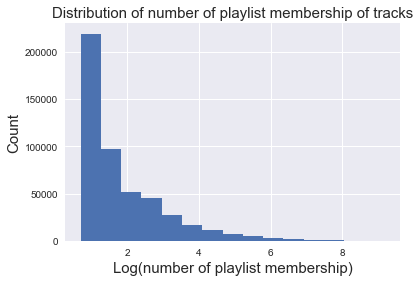

In [4]:
# check number of playlist membership of tracks
n_tr = pd.read_sql_query("select num_member FROM tracks WHERE num_member > 1;", conn)
display(n_tr.describe())

mem = pd.read_sql_query("select num_member FROM tracks WHERE num_member > 1;", conn)
mem.describe()
plt.hist(np.log(np.array(mem)),bins = 15)
plt.xlabel('Log(number of playlist membership)', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of number of playlist membership of tracks', fontsize = 15);

,num_tracks
count,215410.000000
mean,66.185999
std,53.571022
min,5.000000
25%,26.000000
50%,49.000000
75%,91.000000
max,250.000000


Text(0.5,1,'Distribution of number of tracks in playlists')

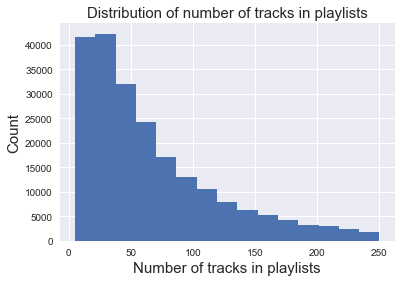

In [5]:
# check number of of tracks in playlists
n_tr = pd.read_sql_query("select num_tracks FROM playlists;", conn)
display(n_tr.describe())
plt.hist(np.array(n_tr),bins = 15)
plt.xlabel('Number of tracks in playlists', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Distribution of number of tracks in playlists', fontsize = 15)

In [1]:
import json
from pprint import pprint
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

In [2]:
songs = glob("lastfm_train/*/*/*/*")

FileNotFoundError: [Errno 2] No such file or directory: 'lastfm_subset/A/A/A/TRAAABD128F429CF47.json'